In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
from scipy.stats import expon, reciprocal

In [ ]:
drive.mount('/content/drive')


unmon_features= pd.read_csv('/content/drive/MyDrive/unmon_features.csv')
mon_features= pd.read_csv('/content/drive/MyDrive/mon_features.csv')
mon_labels = pd.read_csv('/content/drive/MyDrive/mon_labels.csv')


Mounted at /content/drive


In [ ]:
mon_features['label'] = mon_labels.values
unmon_features['label'] = -1

combined_data = pd.concat([mon_features, unmon_features], axis=0, ignore_index= True)
combined_data.fillna(0, inplace=True)

X = combined_data.drop('label', axis=1)
y = combined_data['label']


print(X.head)

<bound method NDFrame.head of        total_num  total_sum_dir  total_avg  inpkt_num  inpkt_avg  inpkt_sum  \
0           1421        -603648   4.315749       1300   4.292023    5579.63   
1            518        -183296   4.611815        438   4.673242    2046.88   
2           1358        -574464   5.488969       1240   5.459452    6769.72   
3           1446        -615424   5.995512       1324   5.948693    7876.07   
4           1406        -602112   4.698869       1291   4.663873    6021.06   
...          ...            ...        ...        ...        ...        ...   
28995       4593       -1928704  12.494690       4180  12.360713   51667.78   
28996       5110       -2158592  13.844609       4663  13.729719   64021.68   
28997        361        -124416   3.568144        302   3.251291     981.89   
28998        509        -162304   6.892377        413   6.689346    2762.70   
28999       9990       -4785152   7.916714       9668   7.923616   76605.52   

       inpkt_num_frac

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=50
)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Train SVM model
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train_scaled, y_train)

# Evaluate model on test data
y_pred = svm_model.predict(X_test_scaled)

# Calculate basic evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Confusion Matrix:\n{conf_matrix}")


Accuracy: 0.4578
Confusion Matrix:
[[1951    1    0 ...    0    0    0]
 [  23    1    1 ...    0    0    0]
 [  29    0   17 ...    0    0    0]
 ...
 [  40    0    0 ...    0    0    0]
 [  15    0    0 ...    0   21    0]
 [  46    0    0 ...    0    0    0]]


In [ ]:
# Define hyperparameter grid for GridSearchCV
param_grid = {
    'C': [100, 200, 300],
    'gamma': [0.1, 0.3],
    'kernel': ['rbf']
}

# Perform GridSearchCV
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy', verbose=2)
grid_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_params = grid_search.best_params_
best_svm_model = grid_search.best_estimator_
print(f"Best parameters (GridSearchCV): {best_params}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  40.5s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  39.1s
[CV] END .......................C=100, gamma=0.1, kernel=rbf; total time=  38.1s
[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  43.7s
[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  43.2s
[CV] END .......................C=100, gamma=0.3, kernel=rbf; total time=  43.3s
[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  39.4s
[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  38.7s
[CV] END .......................C=200, gamma=0.1, kernel=rbf; total time=  38.5s
[CV] END .......................C=200, gamma=0.3, kernel=rbf; total time=  43.0s
[CV] END .......................C=200, gamma=0.3, kernel=rbf; total time=  42.6s
[CV] END .......................C=200, gamma=0.3,

In [ ]:
y_pred = best_svm_model.predict(X_test_scaled)
# Evaluation with the best parameters
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with best parameters: {accuracy:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix with best parameters\n {conf_matrix}")


Accuracy with best parameters: 0.7090
Confusion Matrix with best parameters
 [[1721    3    3 ...    1    0    3]
 [   6   13    0 ...    0    0    2]
 [   9    0   30 ...    0    0    0]
 ...
 [  17    0    0 ...   12    0    0]
 [   1    0    0 ...    0   35    0]
 [   5    0    0 ...    0    0   25]]


In [ ]:
# Define hyperparameter distributions for RandomizedSearchCV
param_distributions = {
    'C': reciprocal(1, 1000),
    'gamma': expon(scale=0.1),
    'kernel': ['rbf'],
    'class_weight': ['balanced', None]
}

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(SVC(), param_distributions, n_iter=50, cv=2, scoring='accuracy', verbose=2, random_state=50, n_jobs=-1)
random_search.fit(X_train_scaled, y_train)

# Retrieve the best model
best_params_random = random_search.best_params_
best_svm_model_random = random_search.best_estimator_
print(f"Best parameters (RandomizedSearchCV): {best_params_random}")

Fitting 2 folds for each of 50 candidates, totalling 100 fits
Best parameters (RandomizedSearchCV): {'C': 218.69176239528977, 'class_weight': None, 'gamma': 0.06980161530282498, 'kernel': 'rbf'}


In [14]:
# 최적 하이퍼파라미터로 SVM 모델 생성
best_svm_model_random = SVC(C=646.0313580382262,
                            class_weight=None,
                            gamma=0.12975790698392028,
                            kernel='rbf',
                            probability=True,  # ROC 및 Precision-Recall Curve를 위해 확률값 필요
                            random_state=42)
best_svm_model_random.fit(X_train_scaled, y_train)
# Predict using the best model from RandomizedSearchCV
y_pred_random = best_svm_model_random.predict(X_test_scaled)

# Evaluate model performance
accuracy_best = accuracy_score(y_test, y_pred_random)
conf_matrix_best = confusion_matrix(y_test, y_pred_random)
precision = precision_score(y_test, y_pred_random, average='micro')  # 'macro'로 설정
recall = recall_score(y_test, y_pred_random, average='macro')        # 'macro'로 설정

# Calculate ROC and Precision-Recall AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_random, pos_label=1)
roc_auc = auc(fpr, tpr)
precision_values, recall_values, _ = precision_recall_curve(y_test, y_pred_random, pos_label=1)
pr_auc = auc(recall_values, precision_values)

# Print metrics
print(f"Accuracy (Tuned Model): {accuracy_best:.4f}")
print(f"Confusion Matrix (Tuned Model):\n{conf_matrix_best}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Precision-Recall AUC: {pr_auc:.4f}")


Accuracy (Tuned Model): 0.6993
Confusion Matrix (Tuned Model):
[[1686    3    3 ...    1    0    4]
 [   7   16    0 ...    0    0    2]
 [  10    0   31 ...    0    0    0]
 ...
 [  14    0    1 ...   17    0    0]
 [   2    0    0 ...    0   35    0]
 [   6    0    0 ...    1    0   25]]
Precision: 0.6993
Recall: 0.6254
ROC AUC: 0.4105
Precision-Recall AUC: 0.0071


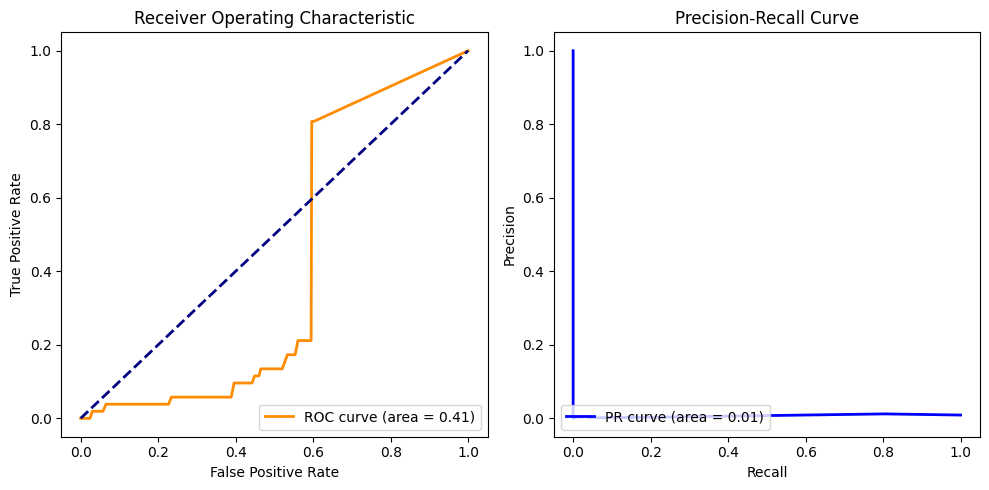

In [15]:
# Plot ROC and Precision-Recall curves
plt.figure(figsize=(10, 5))

# ROC Curve
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(recall_values, precision_values, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()
